In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from keras.datasets import mnist
import sys

### Mathematical functions

Included among them are:
* SIGMOID FUNCTION: $$\sigma(x) = \frac{1}{1+exp(-x)}$$
* LINEAR REGRESSION: $$ f(x) = M x $$
* SINGLE LAYER DL: $$ layer(x) = \sigma( f(x) ) = \frac{1}{1+exp( -(Mx + b) ) }$$
* SOFTMAX: $$ softmax(x) = \frac{exp (x)} {\sum exp(x) } $$
* DERIVATIVE OF SIGMOID: $$ \sigma'(x) = \sigma(x) (1 - \sigma(x))$$

In [3]:
def sigmoid(x):
    return 1./(1+np.exp(-x))

def fx(M, x):
    return np.dot(M, x)

def layer(M, x):
    return sigmoid( fx (M, x) )

def softmax(x):
    return np.exp(x)/np.exp(x).sum()

def sigmoidprime(x):
    return sigmoid(x)*(1 - sigmoid(x))

### Functions for deep learning

In [4]:
def padones(x):
    '''
    Pad every vector in x with ones. Assume x is shaped d x N.
    '''
    return np.concatenate((np.ones((1,x.shape[1])), x ), axis=0)

def initialize(size_in, size_layer1, size_layer2, size_out):
    '''  
    Randomly initialize your parameters. Note that the input is augmented
    by 1 in dimensions for bias terms.
    '''
    M1 = np.random.randn(size_layer1,size_in+1)
    M2 = np.random.randn(size_layer2,size_layer1+1)
    M3 = np.random.randn(size_out,size_layer2+1)
    
    return M1, M2, M3

def forwardprop(M1, M2, M3, X_in):
    '''
    Forward propagate. Before we had this:
    y1 = layer(M1, padones(X_in))
    y2 = layer(M2, padones(y1))
    y3 = layer(M3, padones(y2))
    But for backpropagation, we'll need activations and regressions.
    '''
    z1 = fx(M1, padones(X_in))
    a1 = sigmoid(z1)

    z2 = fx(M2, padones(a1))
    a2 = sigmoid(z2)

    z3 = fx(M3, padones(a2))
    a3 = sigmoid(z3)
    
    return a3

def randomsubset( batchsize, X_train, Y_train ):
    '''
    Pick a random subset of the training set
    '''
    batch = np.random.randint(0,60000,256)
    X_batch = X_train[ :, batch ]
    Y_batch = Y_train[ :, batch ]
    
    return X_batch, Y_batch

### Load the data in. 

#### This is a supervised learning, classification problem

* X_train = training data features
* y_train = training data labels 
* X_test = unseen data features
* y_test = unseen data labels


In [15]:
def load_mnist_data():
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    
    X_train_images= 1.0 - X_train / 255.
    X_test_images=1.0 - X_test / 255.
    
    X_train = X_train.reshape( (len(y_train),28*28) ).transpose(1,0)/255.
    X_test = X_test.reshape( (len(y_test),28*28) ).transpose(1,0)/255.

    Y_train = np.zeros( (10, len(y_train) ) )
    for i in xrange(0, len(y_train)): Y_train[ y_train[i],i ] = 1.0
    Y_test = np.zeros( (10, len(y_test) ) )
    for i in xrange(0, len(y_test)): Y_test[ y_test[i],i ] = 1.0

    # %reset_selective -f y_train
    # %reset_selective -f y_test
    
    return (X_train, Y_train), (X_test, Y_test), (X_train_images, X_test_images)

(X_train, Y_train), (X_test, Y_test), (X_train_images, X_test_images) = load_mnist_data()

### Initialize the variables and set some parameters

* Batch size (var batchsize) is the number of data points we'll look at once
* Learning rate (var lr) is the multiplier of how fast we want to update our gradients
* Iterations (var iterations) is the number of batches we'll go through

We will be randomly initializing our parameters $M^1, M^2, M^3$.


In [6]:
# Learning parameters
batchsize = 256
lr = 1.0
iterations = 10000

# Randomly initialize your parameters
M1, M2, M3 = initialize( 784, 128, 128, 10 )

### Check the accuracy and see how well random initialization does

In [7]:
# Accuracy
Y_predicted = forwardprop( M1, M2, M3, X_test ).argmax(axis=0)
Y_truth = Y_test.argmax(axis=0)
Correct_guesses = (Y_predicted == Y_truth).astype(np.float32).sum()
Total_guesses = np.float32( len(Y_predicted) )
Accuracy = Correct_guesses / Total_guesses * 100.0
print "Accuracy on test dataset is %f%%" % Accuracy

# Cost function value
C = ((Y_test - Y_predicted)**2).sum()/batchsize
print "Cost over the batch is "+str(C)

Accuracy on test dataset is 9.120000%
Cost over the batch is 5053.859375


### Backpropagation

Repeat steps until convergence
1. Get a random subset of X_train and Y_train
2. Forward propagate through the entire network
3. Backpropagate by:
   3. Finding deltas ($ \delta^1, \delta^2, \delta^3 $) of every layer
   3. Calculating the gradients ($ \frac{\partial\mathcal{L}}{\partial M^1}, \frac{\partial\mathcal{L}}{\partial M^2}, \frac{\partial\mathcal{L}}{\partial M^3} $) for every layer with deltas
   3. Update parameters with partial derivatives: $M^i = M^i - \lambda \frac{\partial\mathcal{L}}{\partial M^i}$

Cost = 0.126497997256, Progress 99.9%

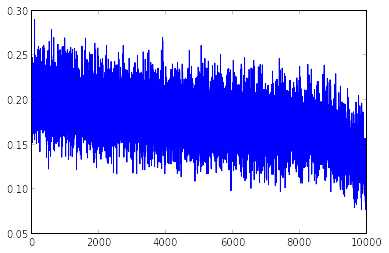

In [10]:
C = np.zeros(iterations)

for iteration in xrange(0, iterations):
    
    X_batch, Y_batch = randomsubset( batchsize, X_train, Y_train )
    
    ''' 
    Forward propagation
    '''
    z1 = fx(M1, padones(X_batch))
    a1 = sigmoid(z1)

    z2 = fx(M2, padones(a1))
    a2 = sigmoid(z2)

    z3 = fx(M3, padones(a2))
    a3 = sigmoid(z3)
    
    '''
    Back propagation
    '''
    delta_3 = -(Y_batch - a3) * sigmoidprime(z3)
    delta_2 = np.dot( M3[:,1:].transpose(1,0), delta_3 ) * sigmoidprime(z2)
    delta_1 = np.dot( M2[:,1:].transpose(1,0), delta_2 ) * sigmoidprime(z1)
                
    # Calculate M gradients
    M3grad = np.dot( delta_3 , a2.transpose(1,0) ) / batchsize
    M2grad = np.dot( delta_2 , a1.transpose(1,0) ) / batchsize
    M1grad = np.dot( delta_1 , X_batch.transpose(1,0) ) / batchsize
    
    # Calculate b gradients
    b3grad = delta_3.sum(axis=1) / batchsize
    b2grad = delta_2.sum(axis=1) / batchsize
    b1grad = delta_1.sum(axis=1) / batchsize
    
    # Update M's
    M3[:,1:] -= lr * M3grad 
    M2[:,1:] -= lr * M2grad
    M1[:,1:] -= lr * M1grad

    # Update b's
    M3[:,0] -= lr*b3grad
    M2[:,0] -= lr*b2grad
    M1[:,0] -= lr*b1grad
    
    # Determine the cost
    C[iteration] = ((Y_batch - a3)**2).sum()/batchsize
    
    if np.mod(iteration,10)==0:
        sys.stdout.write("\rCost = "+str(C[iteration])+", Progress "+str(100*np.float32(iteration)/np.float32(iterations))+"%")
        sys.stdout.flush()
    
plt.plot(C)

### See how well we've done

1. First forward propagate through the test set
2. Then, take a look at what the actual values are
3. Compare the two by taking the indices with the maximum value
4. The accuracy is the percent of correct over total

In [11]:
Y_predicted = forwardprop(M1, M2, M3, X_test).argmax(axis=0)
Y_truth     = Y_test.argmax(axis=0)

Correct_guesses = (Y_predicted == Y_truth).astype(np.float32).sum()
Total_guesses = np.float32( len(Y_predicted) )

Accuracy = Correct_guesses / Total_guesses * 100.0

print "Accuracy on test dataset is %f%%" % Accuracy

Accuracy on test dataset is 90.880001%


### Visualize our predictions

The model predicted 3 and the true value was 3
The image looks like this:


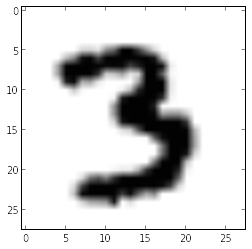

In [18]:
sampleno=500

print("The model predicted %d and the true value was %d"%(Y_predicted[sampleno], Y_truth[sampleno]))
print("The image looks like this:")
plt.imshow(X_test_images[sampleno,:,:], cmap=plt.cm.gray)